In [342]:
import torchdyn
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torchdyn.numerics import Euler, RungeKutta4, Tsitouras45, DormandPrince45
from torchdyn.numerics import odeint

import torchdiffeq
import time 
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [343]:
class VanDerPol(nn.Module):
    def __init__(self, alpha=10):
        super().__init__()
        self.alpha = alpha
        self.nfe = 0

    def forward(self, t, x):
        self.nfe += 1
        x1, x2 = x[...,:1], x[...,1:2]
        return torch.cat([x2, self.alpha * (1 - x1**2) * x2 - x1], -1)

In [344]:
f = VanDerPol()
x = torch.randn(1024, 2)
t_span = torch.linspace(0, 5, 300)

#### Fixed--step bench

In [345]:
t0 = time.time()
t_eval, sol1 = odeint(f, x, t_span, solver='rk4')
t_end1 = time.time() - t0
print(t_end1)

t0 = time.time()
sol2 = torchdiffeq.odeint(f, x, t_span, method='rk4')
t_end2 = time.time() - t0
print(t_end2)

true_sol = torchdiffeq.odeint(f, x, t_span, method='dopri5', atol=1e-9, rtol=1e-9)

0.08901262283325195
0.07811260223388672


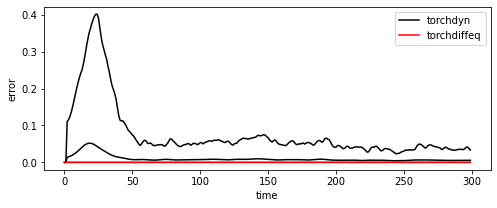

In [346]:
fig = plt.figure(figsize=(8,3))
ax = plt.subplot(111)
line, _ = ax.plot((sol1-true_sol).abs().mean(1), c='black')
line.set_label('torchdyn')
line, _ = ax.plot((sol2-true_sol).abs().mean(1), c='red')
line.set_label('torchdiffeq')
ax.set_ylabel('error')
ax.set_xlabel('time')
plt.legend()

#### Adaptive-step bench

In [347]:
t0 = time.time()
t_eval, sol1 = odeint(f, x, t_span, solver='dopri5', atol=1e-4, rtol=1e-4)
t_end1 = time.time() - t0
print(t_end1)

t0 = time.time()
sol2 = torchdiffeq.odeint(f, x, t_span, method='dopri5', atol=1e-4, rtol=1e-4)
t_end2 = time.time() - t0
print(t_end2)

true_sol = torchdiffeq.odeint(f, x, t_span, method='dopri5', atol=1e-9, rtol=1e-9)

0.18998932838439941
0.15713047981262207


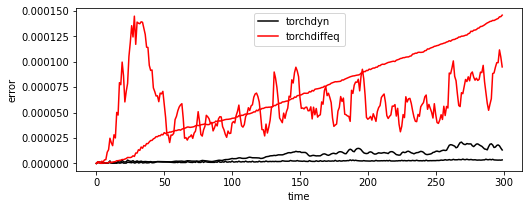

In [348]:
fig = plt.figure(figsize=(8,3))
ax = plt.subplot(111)
line, _ = ax.plot((sol1-true_sol).abs().mean(1), c='black')
line.set_label('torchdyn')
line, _ = ax.plot((sol2-true_sol).abs().mean(1), c='red')
line.set_label('torchdiffeq')
ax.set_ylabel('error')
ax.set_xlabel('time')
plt.legend()

### Using `ODEProblem`

In [349]:
from torchdyn.core import ODEProblem

f = VanDerPol(1)
t_span = torch.linspace(0, 1, 300)
x = torch.randn(1024, 2, requires_grad=True)

##### Backsolve Adjoint

* We are slower when the ODE is easy to solve due to the checkpointing strategy used that slows down `dt`

In [434]:
prob = ODEProblem(f, sensitivity='adjoint', solver='dopri5', atol=1e-5, rtol=1e-5, atol_adjoint=1e-5, rtol_adjoint=1e-5)
t0 = time.time()
t_eval, sol_torchdyn = prob.odeint(x, t_span)
t_end1 = time.time() - t0
print(t_end1)

t0 = time.time()
sol_torchdiffeq = torchdiffeq.odeint_adjoint(f, x, t_span, method='dopri5', atol=1e-5, rtol=1e-5)
t_end2 = time.time() - t0
print(t_end2)

true_sol = torchdiffeq.odeint_adjoint(f, x, t_span, method='dopri5', atol=1e-9, rtol=1e-9)

0.20163774490356445
0.02430129051208496


In [435]:
t0 = time.time()
grad1 = torch.autograd.grad(sol_torchdyn[-1].sum(), x)[0]
t_end1 = time.time() - t0
print(t_end1)

t0 = time.time()
grad2 = torch.autograd.grad(sol_torchdiffeq[-1].sum(), x)[0]
t_end2 = time.time() - t0
print(t_end2)

grad_true = torch.autograd.grad(true_sol[-1].sum(), x)[0]

0.709195613861084
0.9610559940338135


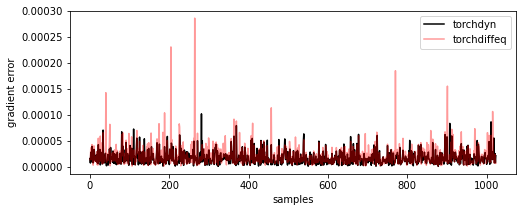

In [436]:
fig = plt.figure(figsize=(8,3))
ax = plt.subplot(111)
ax.plot((grad1-grad_true).abs().sum(1), c='black')
ax.plot((grad2-grad_true).abs().sum(1), c='red', alpha=0.4)
ax.set_ylabel('gradient error')
ax.set_xlabel('samples')
plt.legend(['torchdyn', 'torchdiffeq'])

##### Interpolated Adjoint

In [456]:
t0 = time.time()
prob = ODEProblem(f, sensitivity='interpolated_adjoint', solver='dopri5', atol=1e-5, rtol=1e-5)
t_eval, sol_torchdyn = prob.odeint(x, t_span)
t_end1 = time.time() - t0
print(t_end1)

t0 = time.time()
sol_torchdiffeq = torchdiffeq.odeint_adjoint(f, x, t_span, method='dopri5', atol=1e-5, rtol=1e-5)
t_end2 = time.time() - t0
print(t_end2)

true_sol = torchdiffeq.odeint_adjoint(f, x, t_span, method='dopri5', atol=1e-9, rtol=1e-9)

0.1948246955871582
0.024567127227783203


In [457]:
t0 = time.time()
grad1 = torch.autograd.grad(sol_torchdyn[-1].sum(), x)[0]
t_end1 = time.time() - t0
print(t_end1)

t0 = time.time()
grad2 = torch.autograd.grad(sol_torchdiffeq[-1].sum(), x)[0]
t_end2 = time.time() - t0
print(t_end2)

grad_true = torch.autograd.grad(true_sol[-1].sum(), x)[0]

1.1130650043487549
0.9769954681396484


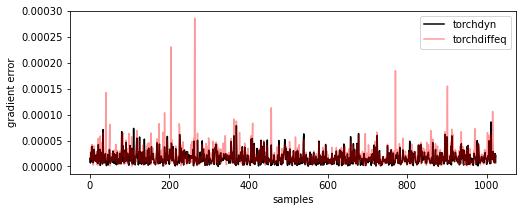

In [460]:
fig = plt.figure(figsize=(8,3))
ax = plt.subplot(111)
ax.plot((grad1-grad_true).abs().sum(1), c='black')
ax.plot((grad2-grad_true).abs().sum(1), c='red', alpha=0.4)
ax.set_ylabel('gradient error')
ax.set_xlabel('samples')
plt.legend(['torchdyn', 'torchdiffeq'])